In [33]:
using Graphs
using DocStringExtensions
using CairoMakie
using Revise
using RNAStructPlot
using LinearAlgebra

g = dotbracket(
    "CGCUUCAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUGAAGUG", 
    "...(((((((..((((((.........))))))......).((((((.......))))))..))))))..."
)

{71, 89} undirected simple Int64 graph

In [28]:
function generate_circular(graph)
    placements = Dict()
    for (i, vertex) in enumerate(vertices(graph))
        x = (i-1)/nv(graph) * 2 * pi
        placements[vertex] = [cos(x), sin(x)]
    end
    return placements
end

generate_circular (generic function with 1 method)

In [ ]:
function draw(g, p)
    f = Figure()
    ax = Axis(f[1,1])

    # draw edges
    for e in edges(g)
        srcx, srcy = p[src(e)]
        dstx, dsty = p[dst(e)]
        lines!([srcx, dstx], [srcy, dsty])
    end
    
    # draw markers
    x = map(v -> p[v][1], vertices(g))
    y = map(v -> p[v][2], vertices(g))
    scatter!(x, y)

    # place labels
    for v in vertices(g)
        vx, vy = p[v]*1.1
        text!(vx, vy,text=string(v),align=(:center, :center),fontsize=1/nv(g),markerspace=:relative)
    end

    ax.aspect = 1
    hidedecorations!(ax)
    hidespines!(ax)

    current_figure()
end

draw (generic function with 1 method)

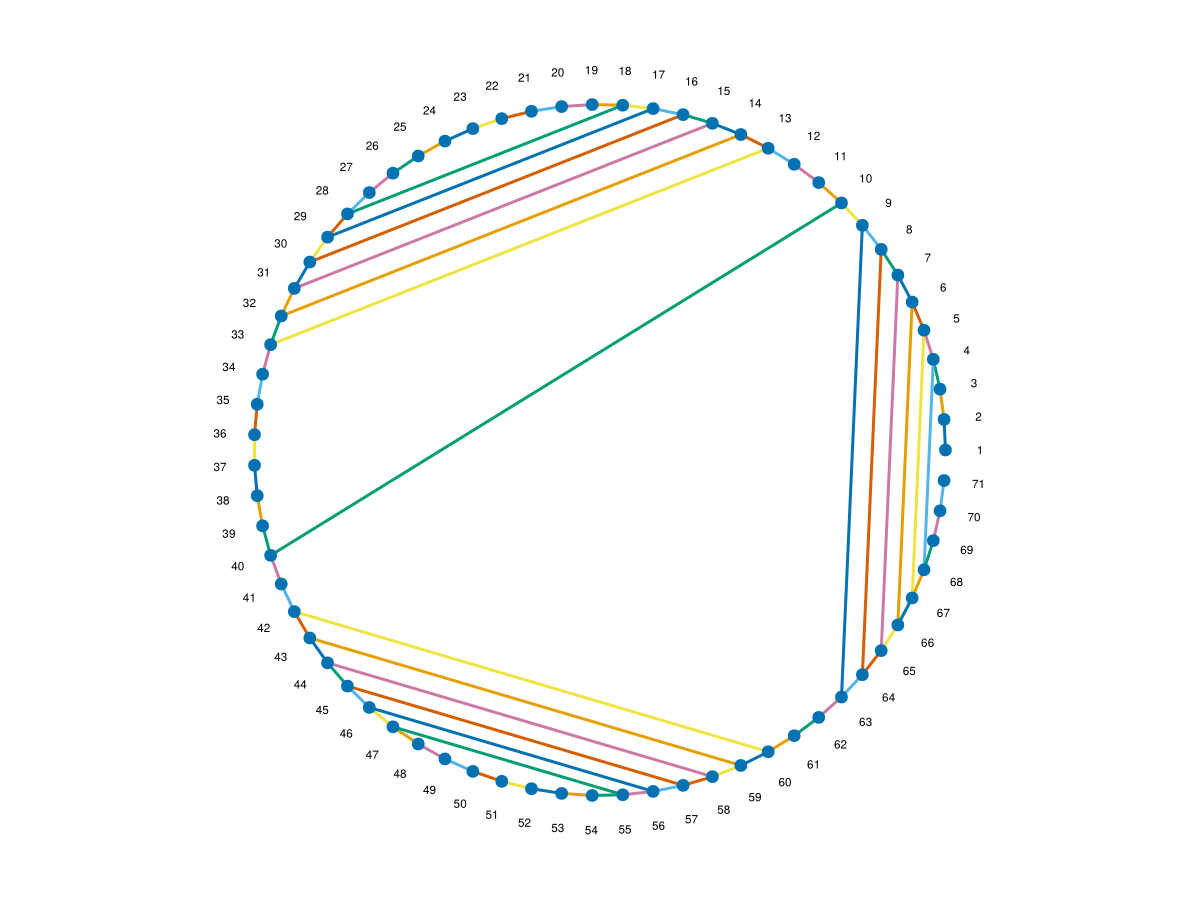

In [34]:
p = generate_circular(g)

draw(g, p)

In [31]:
function bezier2(p1, p2, p3)
    return t -> (1-t)*((1-t)*p1+t*p2) + t*((1-t)*p2+t*p3)
end

bezier2 (generic function with 1 method)

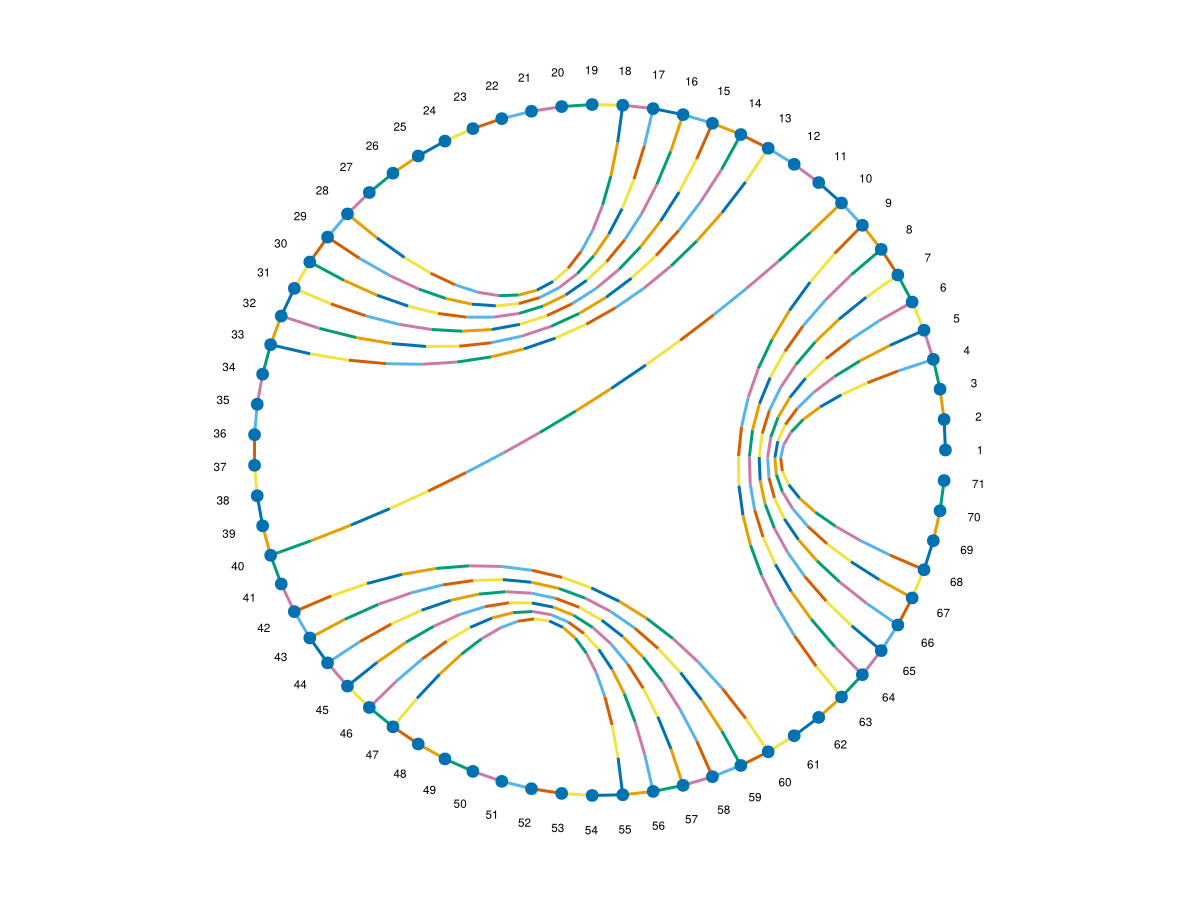

In [35]:
function draw_bezier(g, p)
    f = Figure()
    ax = Axis(f[1,1])
    for e in edges(g)
        start = srcx, srcy = p[src(e)]
        stop = dstx, dsty = p[dst(e)]

        if abs(src(e) - dst(e)) == 1
            lines!([srcx, dstx], [srcy, dsty])
        else
            mid = (start + (stop - start)/2)/10
            #length = norm(stop-start)
            bez = bezier2(start, mid, stop)

            intervals = 16
            for i in range(1, intervals)
                x = (i-1)/intervals
                currx, curry = bez(x)
                nextx, nexty = bez(i/intervals)

                lines!([currx, nextx], [curry, nexty])
            end
            # mbx, mby = stop-mid
            # max, may = start-mid
            # arc!(mid, length/2, atan(may, max), atan(mby, mbx))
        end
    end

    # draw markers
    x = map(v -> p[v][1], vertices(g))
    y = map(v -> p[v][2], vertices(g))
    scatter!(x, y)

    # place labels
    for v in vertices(g)
        vx, vy = p[v]*1.1
        text!(vx, vy,text=string(v),align=(:center, :center),fontsize=1/nv(g),markerspace=:relative)
    end

    ax.aspect = 1
    hidedecorations!(ax)
    hidespines!(ax)

    current_figure()
end

draw_bezier(g, p)